### TAKEHOME 1 - DECISION TREES 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [4]:
# Load CSV
df = pd.read_csv("student_academic_risk_dataset.csv")

# See general info of the dataset
df.info()
# df.describe()
# df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   attendance_percent       1200 non-null   float64
 1   avg_assignment_score     1200 non-null   float64
 2   midterm_score            1200 non-null   float64
 3   study_hours_per_day      1200 non-null   float64
 4   sleep_hours_per_day      1200 non-null   float64
 5   active_backlogs          1200 non-null   int64  
 6   club_activity_per_month  1200 non-null   int64  
 7   screen_time_per_day      1200 non-null   float64
 8   stress_level             1200 non-null   int64  
 9   academic_risk            1200 non-null   int64  
dtypes: float64(6), int64(4)
memory usage: 93.9 KB


In [5]:
df["academic_risk"].value_counts(normalize=True)  
# Percentage of the binary labels occuring

academic_risk
0    0.55
1    0.45
Name: proportion, dtype: float64

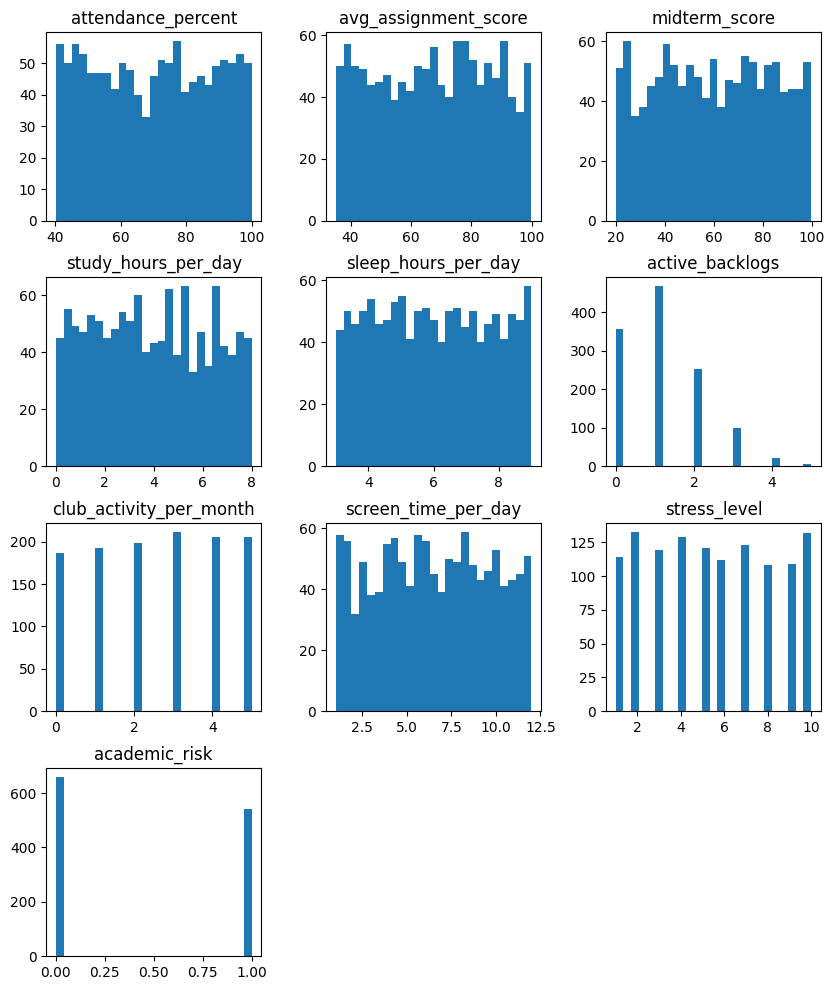

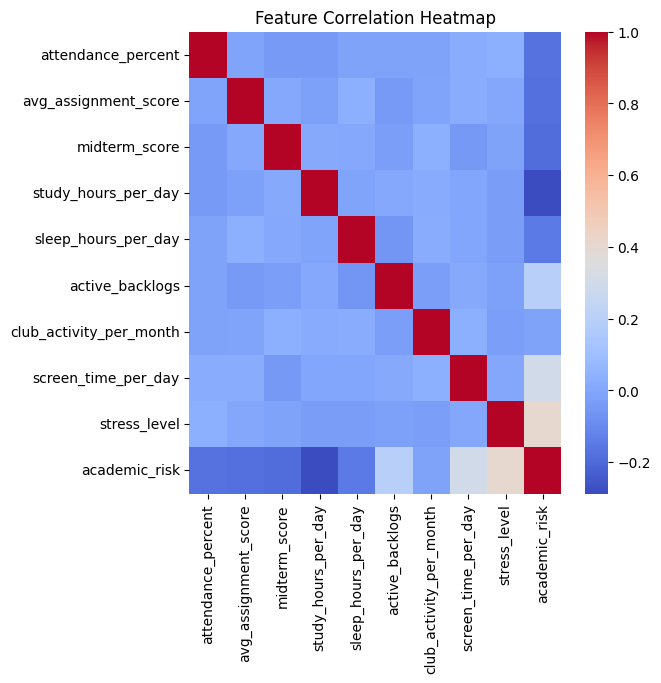

In [6]:
df.hist(bins=25, figsize=(10, 12),grid=False)

plt.figure(figsize=(6, 6))
sns.heatmap(df.corr(), annot=False, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")

plt.show()

- X - features to learn from - everthing except the target
- y - the target to be predicted
- test size -> what percent of data to be taken for testing , rest for training
- random_state  -> same random split every time
- stratify -> make sure the training and test splits have the same class proportions so that theres no wrong prior based on a split having more of a certain class

In [7]:
X = df.drop('academic_risk',axis = 1) 
y = df['academic_risk']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

In [8]:
baseline_model = DecisionTreeClassifier(random_state=42)
baseline_model.fit(X_train, y_train)

train_preds = baseline_model.predict(X_train)
test_preds = baseline_model.predict(X_test)

print("Train accuracy:", accuracy_score(y_train, train_preds))
print("Test accuracy:", accuracy_score(y_test, test_preds))

Train accuracy: 1.0
Test accuracy: 0.6966666666666667


The unconstrained tree achieves perfect training accuracy<br>
the test accuracy is lower, showing high variance/overfitting -> most likely memorized local noise

## Error Analysis

- Precision -> of all predictions for a particular class what % were correct = TP/(TP+FP)
- Recall -> of all instances of a class, how much did it catch = TP/(TP+FN)
- Support -> number of actual occurences of each class in dataset
- f1-score -> 2*(Precision*Recall/(Precision+Recall)) (ranges from 0 to 1)

- confusion matrix tells where the model is confused or what mistake it makes more
- false negatives are more frequent than false positives for the at-risk class, meaning some vulnerable samples are missed

In [9]:
print(classification_report(y_test, test_preds))
print(confusion_matrix(y_test, test_preds))

              precision    recall  f1-score   support

           0       0.73      0.71      0.72       165
           1       0.66      0.68      0.67       135

    accuracy                           0.70       300
   macro avg       0.69      0.70      0.69       300
weighted avg       0.70      0.70      0.70       300

[[117  48]
 [ 43  92]]


## Diagnosing over/underfitting 

- This mainly depends on `min_samples_leaf` and `max_depth`  
  - they control how specific the tree is allowed to get  

- Small `min_samples_leaf` / large `max_depth`  
  - tree can keep splitting  
  - memorizes local noise  
  - low bias, high variance (most error)

- Large `min_samples_leaf` / small `max_depth`  
  - splits are restricted  
  - tree is forced to stay shallow  
  - may ignore real structure  
  - high bias (most error), low variance  

-  `max_depth` - global  `min_samples_leaf` - local 

---

Fixing attempt <br>

Split  
train - (train, validation)  
(fit trees) (choose `max_depth` / `min_samples_leaf`)  

test - evaluate once at the end  

---

## Randomness in trees

- multiple features can give the same information gain at a split  
- without a fixed state, the tree may pick any of them  
- different runs - different splits - different trees - different accuracy  
- trees make greedy, local decisions (min entropy / max info gain)  
- so multiple trees can be equally valid under the objective  

- goal is to generalize to unseen data,so hyperparameters are chosen using validation acc, and final performance is reported on the test set


In [10]:
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42
)
depths = list(range(3, 11)) + [20,30, None] # None means unlimited depth

results = []

for d in depths:
    model = DecisionTreeClassifier(max_depth=d, random_state=42)
    model.fit(X_tr, y_tr)

    train_acc = accuracy_score(y_tr, model.predict(X_tr))
    val_acc = accuracy_score(y_val, model.predict(X_val))

    results.append((d, train_acc, val_acc))

results_df = pd.DataFrame(results, columns=["max_depth", "train_acc", "val_acc"])
best_depth = results_df.loc[results_df["val_acc"].idxmax(), "max_depth"]
print(results_df)
print(f"Best depth (by validation): {best_depth}")
MAX_DEPTH = int(best_depth)

    max_depth  train_acc   val_acc
0         3.0   0.782222  0.626667
1         4.0   0.816296  0.640000
2         5.0   0.850370  0.657778
3         6.0   0.905185  0.657778
4         7.0   0.939259  0.640000
5         8.0   0.970370  0.644444
6         9.0   0.982222  0.644444
7        10.0   0.991111  0.640000
8        20.0   1.000000  0.644444
9        30.0   1.000000  0.644444
10        NaN   1.000000  0.644444
Best depth (by validation): 5.0


In [11]:
min_leaf_range = range(1, 51)

train_accs = []
val_accs = []

for min_leaf in min_leaf_range:
    model = DecisionTreeClassifier(
        max_depth=MAX_DEPTH,
        min_samples_leaf=min_leaf,
        random_state=42
    )
    model.fit(X_tr, y_tr)

    train_accs.append(accuracy_score(y_tr, model.predict(X_tr)))
    val_accs.append(accuracy_score(y_val, model.predict(X_val)))

best_min_leaf = min_leaf_range[np.argmax(val_accs)]

print("Best min_samples_leaf:", best_min_leaf)
print("Train acc at best:", train_accs[np.argmax(val_accs)])
print("Val acc at best:", val_accs[np.argmax(val_accs)])
MIN_SAMPLES_LEAF = best_min_leaf


Best min_samples_leaf: 19
Train acc at best: 0.8192592592592592
Val acc at best: 0.7066666666666667


In [12]:
final_model = DecisionTreeClassifier(
    max_depth=MAX_DEPTH,
    min_samples_leaf=MIN_SAMPLES_LEAF,
    random_state=42
)
final_model.fit(X_train, y_train)
final_train_preds = final_model.predict(X_train)
final_test_preds = final_model.predict(X_test)
print("Final Train accuracy:",accuracy_score(y_train, final_train_preds))
print("Final Test accuracy:",accuracy_score(y_test, final_test_preds))


Final Train accuracy: 0.7977777777777778
Final Test accuracy: 0.7366666666666667


stress_level               0.304581
screen_time_per_day        0.219962
study_hours_per_day        0.212430
attendance_percent         0.109092
midterm_score              0.076071
active_backlogs            0.047944
avg_assignment_score       0.029920
sleep_hours_per_day        0.000000
club_activity_per_month    0.000000
dtype: float64


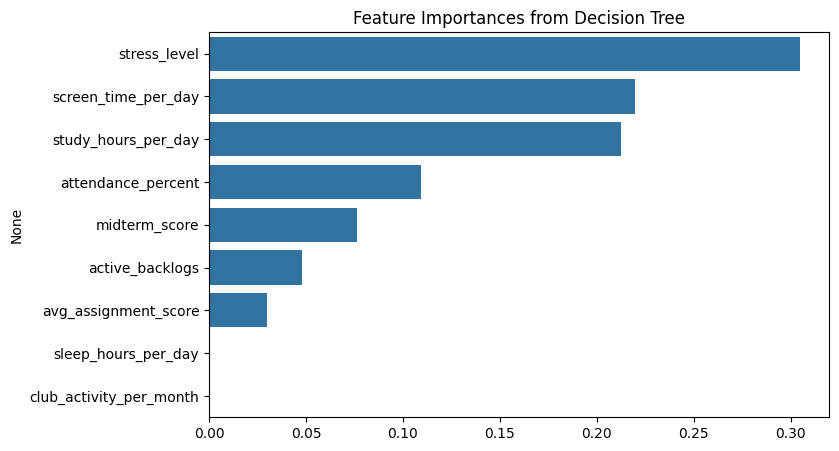

In [13]:
importances = pd.Series(final_model.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)
print(importances)
plt.figure(figsize=(8,5))
sns.barplot(x=importances.values, y=importances.index)
plt.title("Feature Importances from Decision Tree")
plt.show()

In [14]:
analysis_df = X_test.copy()
analysis_df["true"] = y_test.values
analysis_df["pred"] = final_test_preds

errors = analysis_df[analysis_df["true"] != analysis_df["pred"]]
# errors.head()
# errors.describe()
errors.sort_values("study_hours_per_day").head()

,attendance_percent,avg_assignment_score,midterm_score,study_hours_per_day,sleep_hours_per_day,active_backlogs,club_activity_per_month,screen_time_per_day,stress_level,true,pred
1003,57.090430,83.275924,27.088377,0.055024,7.763611,2,3,4.997105,5,1,0
1004,75.019367,36.677774,63.127564,0.109459,5.806324,1,2,5.602122,4,1,0
1022,60.341787,56.905206,31.430077,0.259548,3.410644,4,2,4.876795,2,1,0
22,57.615511,85.855056,45.250188,0.560865,3.072018,1,3,6.851513,1,1,0
1039,65.526186,61.097131,96.606481,0.634242,7.510789,2,4,3.113900,8,0,1


1) Which features dominate the top splits? Why?

Features which provide the most information gain for labelling, reduce entropy the most dominate the top splits <br>
Top most splits should give the most immediate impurity reduction / strongest signal at an early stage<br>

2) Where does the tree fail?

Tree can fail when feature distributions overlap / theres not clear classification when all features give same info gain <br>
Also when a case isnt aligned with the general pattern figured out by the tree

3) What hidden assumptions does the model make?

Correlation implies usefullness for features (for real data correlation doesnt imply causation) <br>
Clear axis for separability exists <br>
Local decisions are sufficient <br>

4) Why does `max_depth` strongly affect generalization?

More depth → lower bias, higher variance<br>
Less depth → higher bias, lower variance<br>
Each level increases hypothesis space<br>

5) Which real-world data issues could break this model?

Noisy measurements<br>
Missing values<br>
Features with no actual correlation to the target<br>
